In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
import time
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss

In [2]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
def plot_games(X_data,y):
    color = np.where(y<=0,'r','b')
    plt.figure(figsize=(13,10))
    plt.scatter(X_data[:, 0], X_data[:, 1], c=color)
    plt.axis('off')
    plt.show()

In [4]:
start_tournament = 2003
stop_tournament = 2018

In [5]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [6]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,...,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [7]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

# Convert types to float to eliminate needless scaler warning 
for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)


In [8]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,...,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1.0,...,8.0,2.0,12.0,5.0,-4.0,34.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13.0,...,-104.0,-133.0,-73.0,-128.0,-85.0,-76.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8.0,...,-36.0,-33.0,-36.0,-33.0,-39.0,-29.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3.0,...,13.0,12.0,17.0,27.0,21.0,9.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2.0,...,2.0,-6.0,-5.0,-8.0,2.0,-5.0,-9.0,2003,0,0


In [9]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [11]:
scaler =StandardScaler(copy=False)

scaler.fit_transform(X[numeric_features])

array([[ 0.34595218,  0.25128547,  0.40445231, ..., -0.09480062,
         0.56418661, -0.56425254],
       [ 0.67253638,  0.56847337, -0.38037777, ..., -1.36037451,
        -1.36325689, -2.24506364],
       [ 0.83582848, -0.35137155,  0.79686735, ..., -0.64165354,
        -0.53971285, -0.35927557],
       ...,
       [ 0.67253638,  0.94909885,  1.97411247, ..., -0.26666868,
         0.0385202 ,  0.67927438],
       [ 1.16241268, -0.09762123,  1.97411247, ..., -0.01667877,
        -0.01404644, -0.195294  ],
       [-0.96038462,  0.85394248, -2.34245297, ...,  0.98328084,
         0.65179768,  0.85692108]])

#### t-Distributed Stochastic Neighbor Embedding

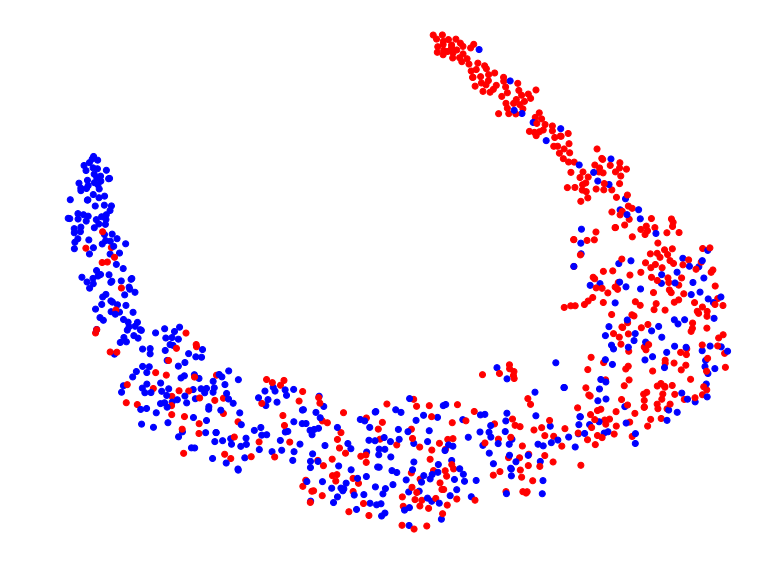

In [17]:
tsne = TSNE(n_components=2, random_state=214)
X_reduced = tsne.fit_transform(X)
plot_games(X_reduced,y)

#### PCA

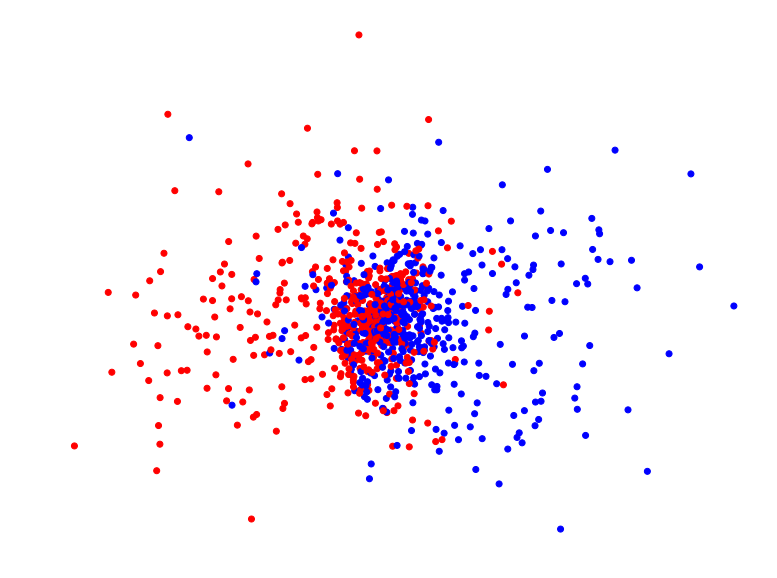

In [18]:
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
plot_games(X_pca_reduced,y)

#### LocallyLinearEmbedding

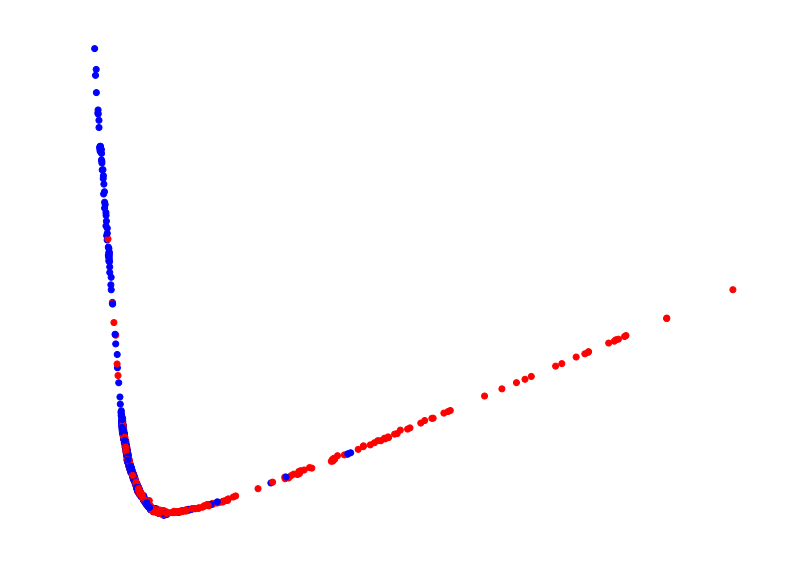

In [19]:
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
plot_games(X_lle_reduced, y)


#### Multidimensional Scaling (MDS)

In [ ]:
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X)
plot_games(X_mds_reduced, y)


#### Classify LLE Reduced Data

In [28]:
stop_tournament = 2017
X= feature_data[feature_data['season_t']<= stop_tournament]
X= X.drop(columns=['season_t'])
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)

In [30]:
scaler.fit_transform(X_train[numeric_features])
scaler.fit_transform(X_test[numeric_features])

array([[-0.08489588, -0.11551193, -1.87207263, ..., -0.04611168,
         0.14234004, -0.08359018],
       [-1.08327148,  0.78876197,  0.37212453, ...,  0.42251962,
         0.21930183,  0.13522352],
       [ 0.24789598,  0.0519462 , -0.37594119, ..., -0.29716416,
        -0.68499919, -0.16564532],
       ...,
       [ 0.58068785, -0.68486958, -0.00190833, ...,  0.02083565,
        -0.16550711,  0.02581667],
       [ 0.41429191,  0.58781221, -0.37594119, ..., -0.09632218,
         0.02689736, -0.19299704],
       [ 1.07987564,  0.52082896, -0.37594119, ..., -0.63190081,
        -0.78120143, -0.26137632]])

In [31]:
X_train_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_train)
X_test_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_test)

In [32]:
logreg = LogisticRegression(solver='liblinear')
result = logreg.fit(X_train_reduced,y_train)
y_pred = logreg.predict(X_test_reduced)

array([[12, 77],
       [42, 65]], dtype=int64)

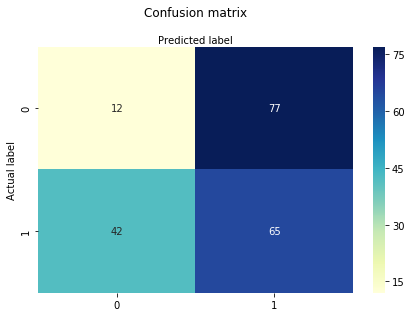

In [33]:
utils.display_confusion_matrix(y_test, y_pred)

In [36]:
prediction_probabilities = logreg.predict_proba(X_test_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.39285714285714285
Precision: 0.45774647887323944
Recall: 0.6074766355140186
Log loss=  0.7644288174455232
